<a href="https://colab.research.google.com/github/smore88/housing-market-predictions/blob/main/houseMarketAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

House Price Regression Project

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

Created By: Shubham More



# Importing Data & Packages

In [ ]:
!pip install joblib

In [ ]:
import numpy as np
from google.colab import drive
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
from joblib import dump

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
drive.mount('/content/gdrive/')
datadir = "/content/gdrive/MyDrive/CS441/24SP/finalProject/house-prices-advanced-regression-techniques/" # TO DO: set up ur directory in drive to be this here
train_data = pd.read_csv(datadir + 'train.csv', index_col=0)
test_data = pd.read_csv(datadir + 'test.csv', index_col=0)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [ ]:
train_data.isna().sum().sum()

7829

In [ ]:
print(train_data['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [ ]:
data = [go.Histogram(x=train_data['SalePrice'])]

layout = go.Layout(
    title='Histogram of Sales Price',
    xaxis=dict(title='Sales Price'),
    yaxis=dict(title='Frequency')
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
df_num = train_data.select_dtypes(include=['float64', 'int64'])

rows = 6
cols = 6

fig = make_subplots(rows=rows, cols=cols, subplot_titles=df_num.columns)

for i, col in enumerate(df_num.columns[:-1]):
    row_num = i // cols + 1
    col_num = i % cols + 1
    hist = go.Histogram(x=df_num[col], name=col)
    fig.add_trace(hist, row=row_num, col=col_num)

fig.update_layout(height=1500, width=1500, title='Histograms of Numerical Columns', showlegend=False)
fig.show()

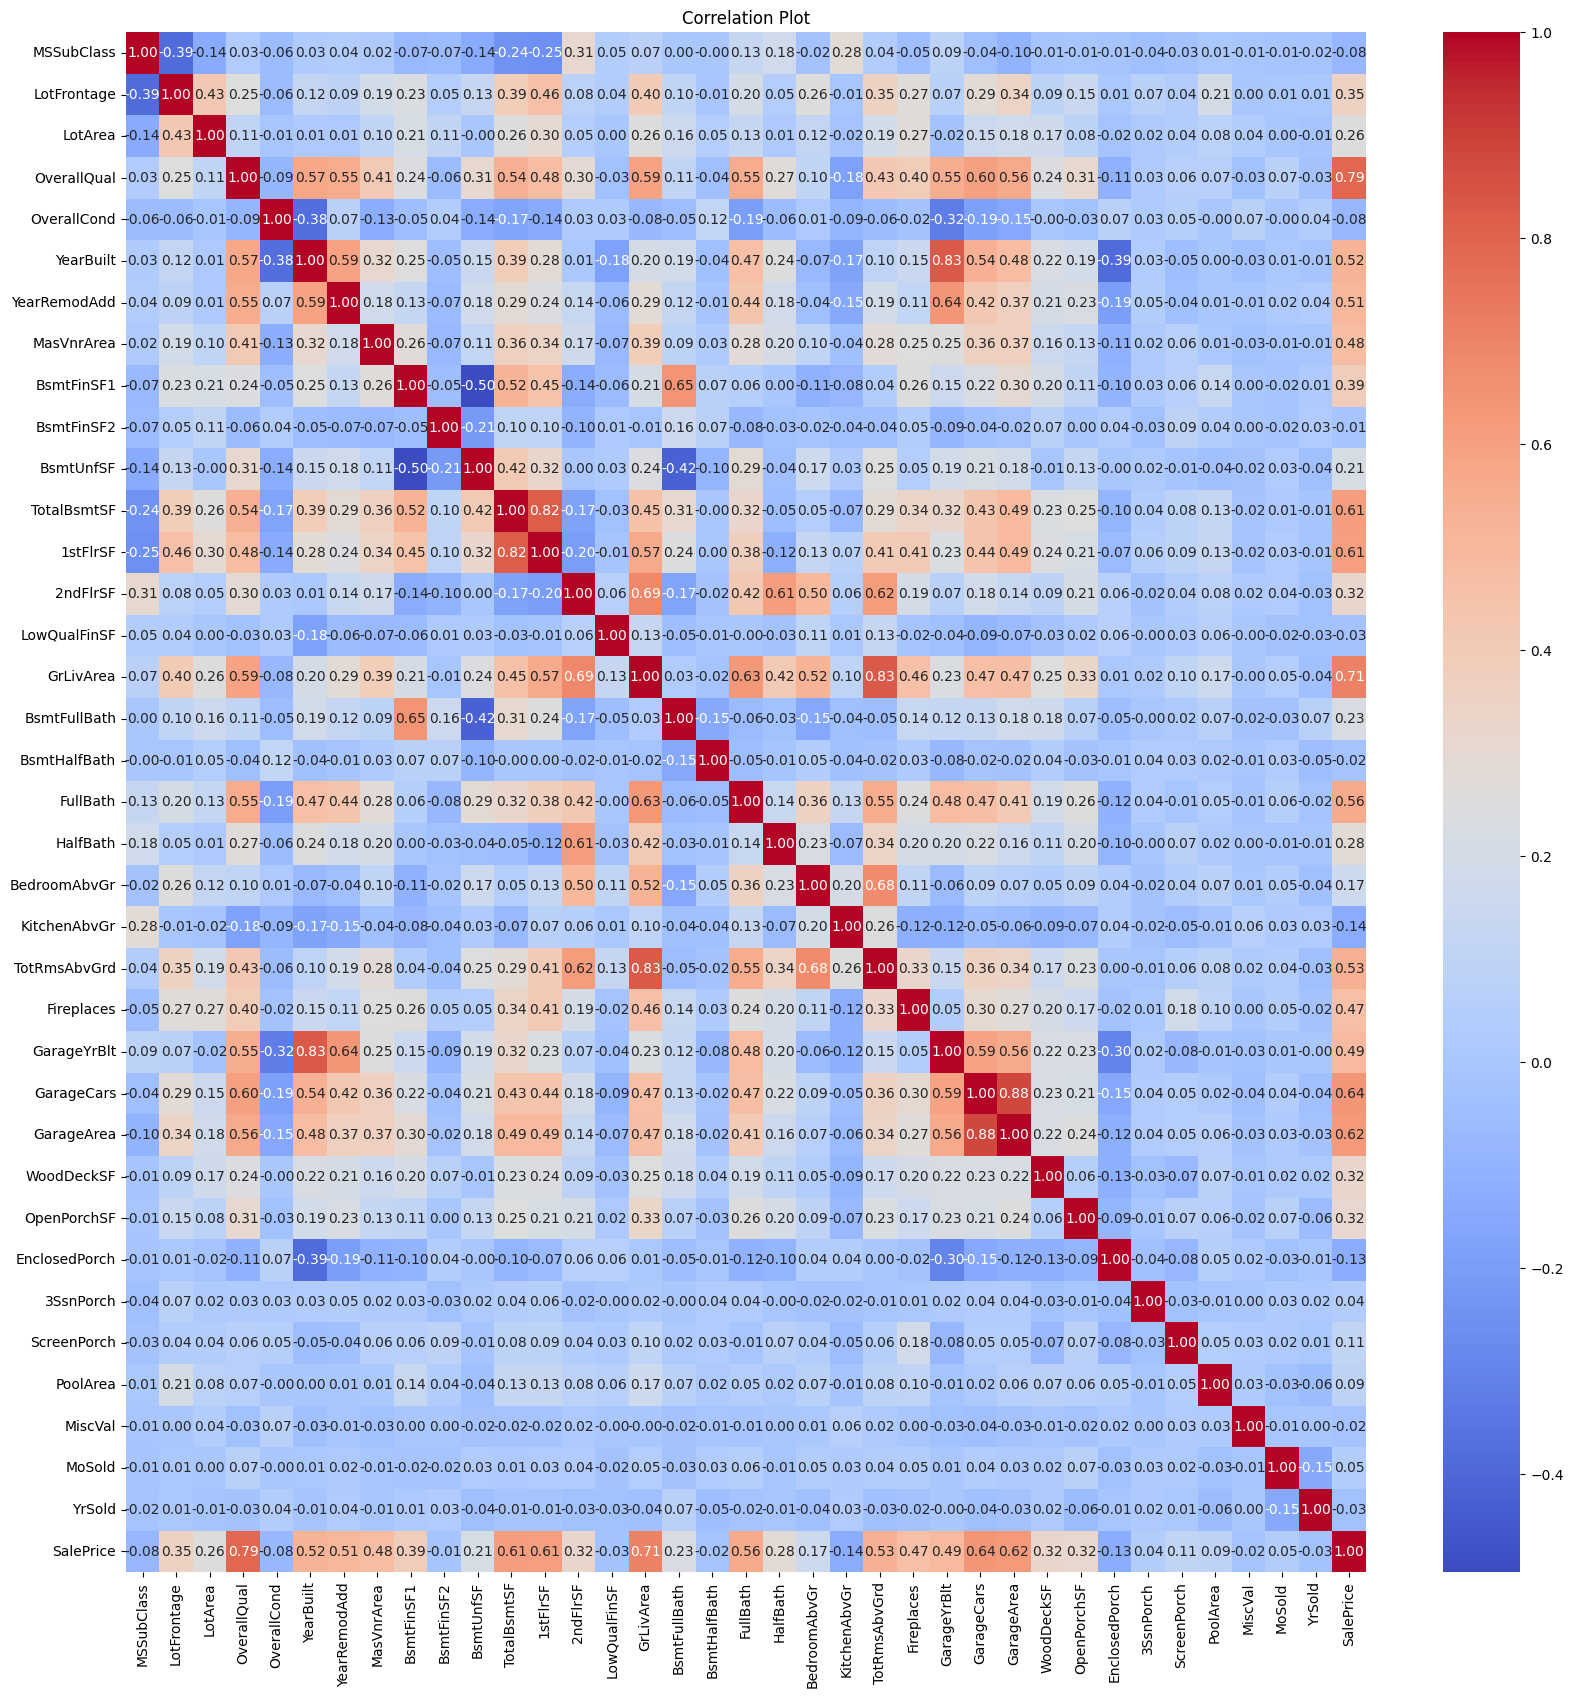

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
df_num = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = df_num.corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

In [ ]:
train_data = pd.read_csv(datadir + 'train.csv')
test_data = pd.read_csv(datadir + 'test.csv')

# Random Forest

#### Feature Engineering

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
'''
Seperate target from the predictors
'''
y = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [ ]:
'''
Seperate target from the predictors
'''
y = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

'''
Find the columns from the training data that are numerical vs not numerical.

Tree Classification Algos like Random Forest handle cardinality better than Linear models but still lets not include categorical features with
nunique > 10 as it may pose challenges like overfitting. (this is for nonNumericalCols)
'''
def identify_columns(data):
    numerical_cols = []
    categorical_cols = []
    for col in data.columns:
        if data[col].dtype == "int64" or data[col].dtype == "float64":
            numerical_cols.append(col)
        elif data[col].dtype == "object" and data[col].nunique() < 10:
            categorical_cols.append(col)
    return numerical_cols, categorical_cols

numericalCols, categoricalCols = identify_columns(X_train)
numericalColsTest, categoricalColsTest = identify_columns(X_test)
numericalColsVal, categoricalColsVal = identify_columns(X_val)

In [ ]:
# Preprocess the numericalCols: any missing vals in cols replace with the median of that column
numerical_transformer = SimpleImputer(strategy='median')

# Preprocess categorical data: imputer will handle the missing vals by replacing the vals with the most frequent in that col, onehot turns val into one hot encoded vector
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

#### Identify Key Hyperparameters & Define Model

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', grid_search)
])

# grid search will look at the different combinations of the param grid and keep track of the neg_mean_squared_error for each model it fits
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'Ful...
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', 'FireplaceQu', ...])])),
                ('model',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=0),
                              param_grid={'max_depth': [2, 4, 8, 16, 32],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 200]},
                              scoring='neg_mean_squared_error'))])

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'rmse'],
      dtype='object')


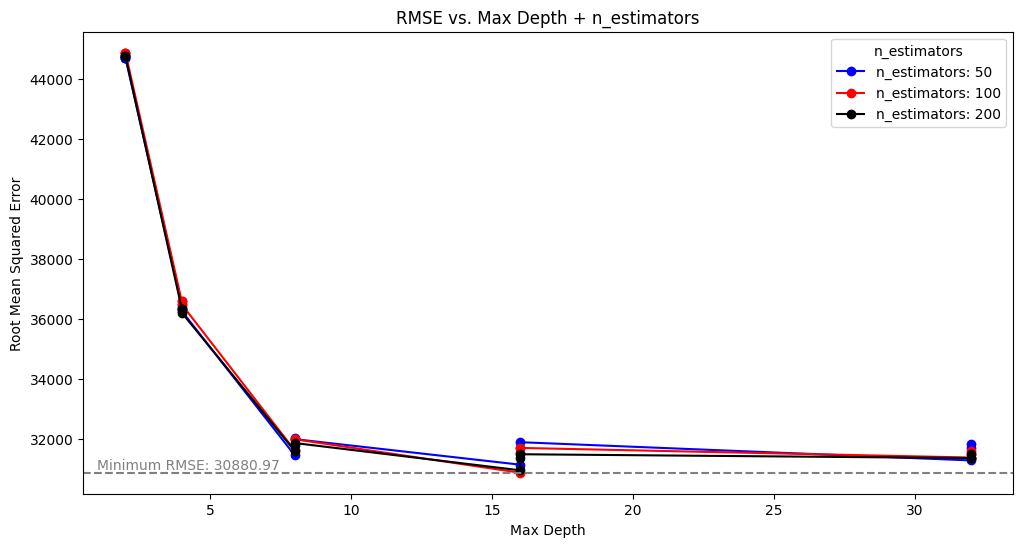

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)
results_df['rmse'] = np.sqrt(-results_df['mean_test_score']) # created new column for the RMSE
results_df_traditional = results_df
print(results_df.columns)

colors = {50: 'blue', 100: 'red', 200: 'black'}
estimators_values = results_df['param_n_estimators'].unique()

# Plot how RMSE changes with the max_depth + n_estimators
plt.figure(figsize=(12, 6))
for n in estimators_values:
    subset = results_df[results_df['param_n_estimators'] == n] # create df of just rows with n=50 for example
    plt.plot(subset['param_max_depth'], subset['rmse'], label=f'n_estimators: {n}', color=colors[n], marker='o')

# Get the min RMSE val and draw a dotted line there
min_rmse = results_df['rmse'].min()
plt.axhline(y=min_rmse, color='gray', linestyle='--', linewidth=1.5)
plt.text(x=1, y=min_rmse, s=f'Minimum RMSE: {min_rmse:.2f}', color='gray', va='bottom')

plt.title(f'RMSE vs. Max Depth + n_estimators')
plt.xlabel('Max Depth')
plt.ylabel('Root Mean Squared Error')
plt.legend(title='n_estimators')
plt.show()

In [ ]:
results_df.to_csv("temp.csv")

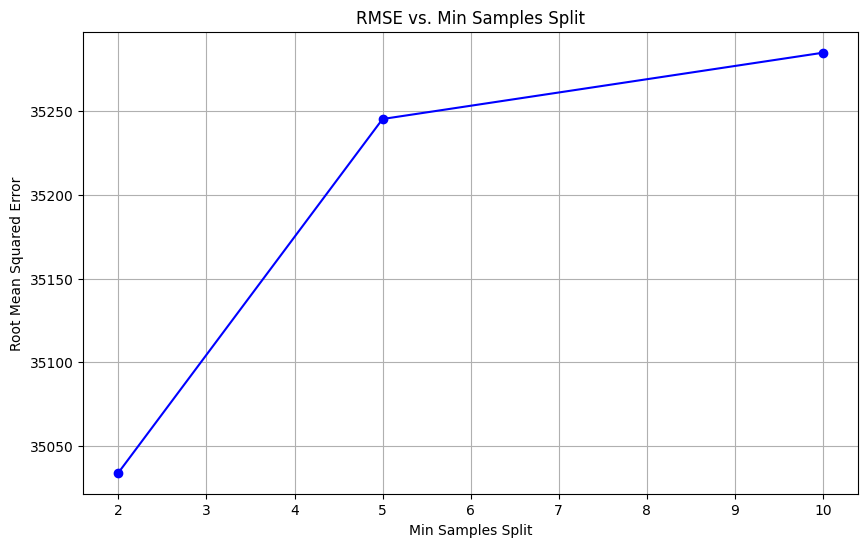

In [ ]:
grouped_min_samples = results_df.groupby('param_min_samples_split') # get a df object that is is grouped by the min_samples_split
mean_rmse = grouped_min_samples['rmse'].mean() # get the mean of each group
# print(f"Mean of each min_sample tested is: {mean_rmse}")
mean_rmse_df = mean_rmse.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_rmse_df['param_min_samples_split'], mean_rmse_df['rmse'], marker='o', linestyle='-', color='blue')
plt.title('RMSE vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

best_model = pipeline.named_steps['model'].best_estimator_
best_params = pipeline.named_steps['model'].best_params_
best_score = pipeline.named_steps['model'].best_score_
best_rmse = np.sqrt(-best_score)

print("Best Hyperparameters:", best_params)
print("Best RMSE(lowest):", best_rmse)

Best Hyperparameters: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE(lowest): 30880.96695528554


#### Evaluate best model against X_val, y_val

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = pipeline.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)
# RMSE is a deviation error that we can use to see in general it looks like we are $28,550 off the actual price

Root Mean Squared Error (RMSE) on Validation Set: 28550.497769631103


In [ ]:
predictions = pipeline.predict(X_test)

In [ ]:
print("Columns in test_data DataFrame:")
print(test_data.columns)

Columns in test_data DataFrame:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',


In [ ]:
output = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


# Support Vector Regression (SVR)

#### Identify Hyperparameters & Define Model

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder # SVMs benefit from feature scaling
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import numpy as np

In [ ]:
# Preprocess the numericalCols: any missing vals in cols replace with the median of that column apply standardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocess categorical data: imputer will handle the missing vals by replacing the vals with the most frequent in that col, onehot turns val into one hot encoded vector
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define a column transformer that applies OneHotEncoder to categorical columns and StandardScaler to numerical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR())
])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Id',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtS...
                                                                          'BsmtQual',
                                                                          'BsmtCond',
                                                                          'BsmtExposure',
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'Functional',
                                                                          'FireplaceQu', ...])])),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
svr_best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_rmse = np.sqrt(-best_score)

# print("Best Model:", best_model)
print("Best Hyperparameters:", best_params)
print("Best RMSE(lowest):", best_rmse)

Best Hyperparameters: {'svr__C': 0.1, 'svr__gamma': 1, 'svr__kernel': 'poly'}
Best RMSE(lowest): 30999.06083977105


#### Evaluate best model against X_val, y_val

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = svr_best_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 25985.16735786661


In [ ]:
predictions = svr_best_model.predict(X_test)

In [ ]:
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': predictions})
output.to_csv('submissionSVR.csv', index=False)
print("Submission saved!")

Submission saved!


# Multi-Layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
'''
Seperate target from the predictors
'''
y = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [ ]:
'''
Find the columns from the training data that are numerical vs not numerical.

Tree Classification Algos like Random Forest handle cardinality better than Linear models but still lets not include categorical features with
nunique > 10 as it may pose challenges like overfitting. (this is for nonNumericalCols)
'''
def identify_columns(data):
    numerical_cols = []
    categorical_cols = []
    for col in data.columns:
        if data[col].dtype == "int64" or data[col].dtype == "float64":
            numerical_cols.append(col)
        elif data[col].dtype == "object" and data[col].nunique() < 10:
            categorical_cols.append(col)
    return numerical_cols, categorical_cols

numericalCols, categoricalCols = identify_columns(X_train)
numericalColsTest, categoricalColsTest = identify_columns(X_test)
numericalColsVal, categoricalColsVal = identify_columns(X_val)

In [ ]:
# Preprocess the numericalCols: any missing vals in cols replace with the median of that column apply standardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocess categorical data: imputer will handle the missing vals by replacing the vals with the most frequent in that col, onehot turns val into one hot encoded vector
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define a column transformer that applies OneHotEncoder to categorical columns and StandardScaler to numerical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

# Setting up a new pipeline with MLPRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(random_state=42, max_iter=500))
])

# Define a parameter grid for the MLP, tuning hidden layer sizes, activation, and solver
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}

# Set up GridSearchCV to find the best model parameters
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Id',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtS...
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'Functional',
                                                                          'FireplaceQu', ...])])),
                                       ('mlp',
                                        MLPRegressor(max_iter=500,
                                                     random_state=42))]),
             param_grid={'mlp__activation': ['tanh', 'relu'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                     (100, 100)],
                         'mlp__solver': ['sgd', 'adam']},
             scoring='neg_mean_squared_error', verbose=1)

#### Evaluate best model against X_val, y_val

In [ ]:
mlp_best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_rmse = np.sqrt(-best_score)

# print("Best Model:", best_model)
print("Best Hyperparameters:", best_params)
print("Best RMSE(lowest):", best_rmse)

Best Hyperparameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__solver': 'adam'}
Best RMSE(lowest): 35953.74061988188


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = mlp_best_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 33573.70729149279


In [ ]:
predictions = mlp_best_model.predict(X_test)

In [ ]:
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': predictions})
output.to_csv('submissionMLP.csv', index=False)
print("Submission saved!")

Submission saved!


# Finding Best Model on Entire Training Data(train + val)

In [ ]:
print(X_test.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# rather than a train, val split, combine together and train the best
y_train = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)
X_test = test_data

numericalCols1, categoricalCols1 = identify_columns(X_train)
numericalColsTest1, categoricalColsTest1 = identify_columns(X_test)

# imputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocess the data
preprocessor_train = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols1),
    ('cat', categorical_transformer, categoricalCols1)
])
preprocessor_test = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalColsTest1),
    ('cat', categorical_transformer, categoricalColsTest1)
])
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train Random Forest Regressor
rf = RandomForestRegressor(max_depth=16, min_samples_split=2, n_estimators=100)
rf.fit(X_train_preprocessed, y_train)
rf_pred = rf.predict(X_test_preprocessed)
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': rf_pred})
output.to_csv('bestRFModelResults.csv', index=False)
print("Submission saved!")

# Train Support Vector Regressor
svr = SVR(C=0.1, gamma=1, kernel='poly')
svr.fit(X_train_preprocessed, y_train)
svr_pred = svr.predict(X_test_preprocessed)
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': svr_pred})
output.to_csv('bestSVRModelResults.csv', index=False)
print("Submission saved!")

# Train Multi-layer Perceptron Regressor
mlp = MLPRegressor(activation='relu', alpha=0.01, hidden_layer_sizes=(100, 100), solver='adam')
mlp.fit(X_train_preprocessed, y_train)
mlp_pred = mlp.predict(X_test_preprocessed)
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': mlp_pred})
output.to_csv('bestMLPModelResults.csv', index=False)
print("Submission saved!")

Submission saved!
Submission saved!
Submission saved!


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



# Part 3. Additional Analysis (Training Size)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

'''
Seperate target from the predictors
'''
y = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [ ]:
'''
Find the columns from the training data that are numerical vs not numerical.

Tree Classification Algos like Random Forest handle cardinality better than Linear models but still lets not include categorical features with
nunique > 10 as it may pose challenges like overfitting. (this is for nonNumericalCols)
'''
def identify_columns(data):
    numerical_cols = []
    categorical_cols = []
    for col in data.columns:
        if data[col].dtype == "int64" or data[col].dtype == "float64":
            numerical_cols.append(col)
        elif data[col].dtype == "object" and data[col].nunique() < 10:
            categorical_cols.append(col)
    return numerical_cols, categorical_cols

numericalCols, categoricalCols = identify_columns(X_train)
numericalColsTest, categoricalColsTest = identify_columns(X_test)
numericalColsVal, categoricalColsVal = identify_columns(X_val)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# Define the range of training sizes
train_sizes = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9]

# Initialize lists to store results
rmse_list_rfr = []

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessor to apply transformers to numerical and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

# Define best hyperparameters
best_params =  {'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 100}

# Define pipeline with preprocessor and SVR model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfr', RandomForestRegressor(**best_params))
])

# Iterate over different training sizes
for size in train_sizes:
    # Split the data into training and validation sets
    x_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)

    # Train the model
    pipeline.fit(x_train_subset, y_train_subset)

    # Predict on the validation set
    y_val_pred = pipeline.predict(X_val)

    # Evaluate performance (you might want to change this depending on your problem)
    # For regression, you could use mean squared error or R^2
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)

    # Store the accuracy for this training size
    rmse_list_rfr.append(rmse)

# Create a dataframe to store the results
results_df = pd.DataFrame({'Training Size': [f'{size*100}%' for size in train_sizes],
                           'Validation RMSE': rmse_list_rfr})

# Print the results
print(results_df)

  Training Size  Validation RMSE
0          1.0%     58329.748281
1          5.0%     48883.092545
2         10.0%     41053.311520
3         25.0%     36694.937966
4         50.0%     31337.481963
5         75.0%     30531.463320
6         90.0%     29343.879598


In [ ]:
# Define the range of training sizes
train_sizes = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9]

# Initialize lists to store results
rmse_list_svr = []

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessor to apply transformers to numerical and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

# Define best hyperparameters
best_params = {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}

# Define pipeline with preprocessor and SVR model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR(**best_params))
])

# Iterate over different training sizes
for size in train_sizes:
    # Split the data into training and validation sets
    x_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)

    # Train the model
    pipeline.fit(x_train_subset, y_train_subset)

    # Predict on the validation set
    y_val_pred = pipeline.predict(X_val)

    # Evaluate performance (you might want to change this depending on your problem)
    # For regression, you could use mean squared error or R^2
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)

    # Store the accuracy for this training size
    rmse_list_svr.append(rmse)

# Create a dataframe to store the results
results_df = pd.DataFrame({'Training Size': [f'{size*100}%' for size in train_sizes],
                           'Validation RMSE': rmse_list_svr})

# Print the results
print(results_df)

  Training Size  Validation RMSE
0          1.0%     63861.035228
1          5.0%     44693.755880
2         10.0%     37358.140896
3         25.0%     24955.572355
4         50.0%     24551.975718
5         75.0%     27603.579971
6         90.0%     26044.437565


In [ ]:
from sklearn.neural_network import MLPRegressor

# Define best hyperparameters for MLP
best_params = {'activation': 'relu',
               'alpha': 0.01,
               'hidden_layer_sizes': (100, 100),
               'solver': 'adam'}

# Define pipeline with preprocessor and MLP model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(**best_params))
])

# Initialize lists to store results
rmse_list_mlp = []

# Iterate over different training sizes
for size in train_sizes:
    # Split the data into training and validation sets
    x_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)

    # Train the model
    pipeline.fit(x_train_subset, y_train_subset)

    # Predict on the validation set
    y_val_pred = pipeline.predict(X_val)

    # Evaluate performance (you might want to change this depending on your problem)
    # For regression, you could use mean squared error or R^2
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)

    # Store the accuracy for this training size
    rmse_list_mlp.append(rmse)

# Create a dataframe to store the results
results_df = pd.DataFrame({'Training Size': [f'{size*100}%' for size in train_sizes],
                           'Validation RMSE': rmse_list_mlp})

# Print the results
print(results_df)

  Training Size  Validation RMSE
0          1.0%    190736.830477
1          5.0%    189416.385268
2         10.0%    188356.422607
3         25.0%    119211.809597
4         50.0%     51291.188033
5         75.0%     40041.949784
6         90.0%     38172.628279


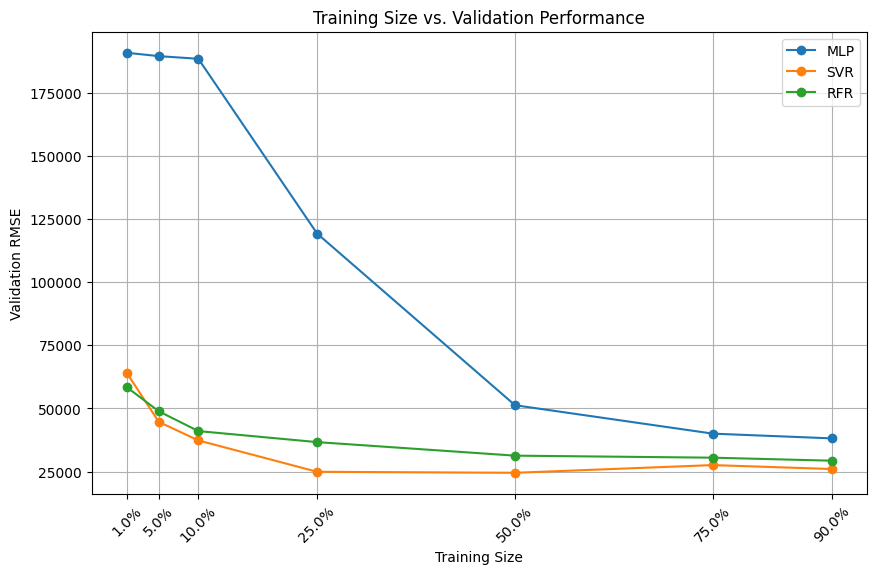

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, rmse_list_mlp, marker='o', label='MLP')
plt.plot(train_sizes, rmse_list_svr, marker='o', label='SVR')
plt.plot(train_sizes, rmse_list_rfr, marker='o', label='RFR')
plt.title('Training Size vs. Validation Performance')
plt.xlabel('Training Size')
plt.ylabel('Validation RMSE')
plt.xticks(train_sizes, [f'{size*100}%' for size in train_sizes], rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Part 4. Stretch Goals (Innovation)

## Using Linear Regression to Inpute Missing Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

class SelectNumericalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=['float64', 'int64'])

class LinearRegressionImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.columns:
          if X[column].isna().sum()>0:

                correlation_columns = X.corr()[column].sort_values(ascending=False)


                highly_correlated_features = correlation_columns[abs(correlation_columns) > 0.4 ].index.tolist()
                X_filtered = X.dropna(subset=highly_correlated_features + [column])
                X_train = X_filtered[highly_correlated_features]
                y_train = X_filtered[column]

                model = LinearRegression()
                model.fit(X_train, y_train)

                for index, row in X_train.iterrows():
                  if pd.isnull(row[column]):
                      features = row[highly_correlated_features[:-1]]
                      predicted_values = model.predict(features.values.reshape(1, -1))
                      X_train.at[index, column] = predicted_values[0]

        return X

class RandomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns_with_missing_data = X.columns[X.isna().any()].tolist()
        for column in columns_with_missing_data:
            random_values = [random.choice(X[column].dropna().values) for _ in range(X[column].isna().sum())]
            X.loc[X[column].isna(), column] = random_values
        return X

In [ ]:
train_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('linear_regression_imputer', LinearRegressionImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
train_data_processed = train_pipeline.fit_transform(train_data)

# Check for any remaining missing values
print(train_data_processed.isna().sum().sum())

test_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('linear_regression_imputer', LinearRegressionImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
test_data_processed = test_pipeline.fit_transform(test_data)

# Check for any remaining missing values
print(test_data_processed.isna().sum().sum())

0
0


### Evaluating using RandomForestRegressor

In [ ]:
from sklearn.model_selection import train_test_split

y = train_data_processed['SalePrice']
x_train = train_data_processed.drop(['SalePrice'], axis=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=0)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit grid search on training data
grid_search.fit(x_train, y_train)

# Get best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)


Best Parameters: {'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 50}
Best Estimator: RandomForestRegressor(max_depth=16, min_samples_split=10, n_estimators=50,
                      random_state=0)


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = grid_search.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 30921.341810502854


### Evaluating using XGBRegressor

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(x_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Rebuild XGBoost model with best parameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Train the model with best parameters
best_xgb_model.fit(x_train, y_train)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_val_pred = best_xgb_model.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 27579.08631456235


### Evaluating using ExtraTreeRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Extra Trees regressor
et_model = ExtraTreesRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(x_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Rebuild Extra Trees model with best parameters
best_et_model = ExtraTreesRegressor(**best_params)

# Train the model with best parameters
best_et_model.fit(x_train, y_train)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


ExtraTreesRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=300)

In [ ]:
y_val_pred = best_et_model.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 27956.465799718524


## Using Random Forest to Fill in Missing Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

class SelectNumericalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=['float64', 'int64'])

class RandomForestImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.columns:
          if X[column].isna().sum()>0:

                correlation_columns = X.corr()[column].sort_values(ascending=False)


                highly_correlated_features = correlation_columns[abs(correlation_columns) > 0.4 ].index.tolist()
                X_filtered = X.dropna(subset=highly_correlated_features + [column])
                X_train = X_filtered[highly_correlated_features]
                y_train = X_filtered[column]

                model = RandomForestRegressor()
                model.fit(X_train, y_train)

                for index, row in X_train.iterrows():
                  if pd.isnull(row[column]):
                      features = row[highly_correlated_features[:-1]]
                      predicted_values = model.predict(features.values.reshape(1, -1))
                      X_train.at[index, column] = predicted_values[0]

        return X

class RandomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns_with_missing_data = X.columns[X.isna().any()].tolist()
        for column in columns_with_missing_data:
            random_values = [random.choice(X[column].dropna().values) for _ in range(X[column].isna().sum())]
            X.loc[X[column].isna(), column] = random_values
        return X

In [ ]:
train_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('random_forest_imputer', RandomForestImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
train_data_processed = train_pipeline.fit_transform(train_data)

# Check for any remaining missing values
print(train_data_processed.isna().sum().sum())

test_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('random_forest_imputer', RandomForestImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
test_data_processed = test_pipeline.fit_transform(test_data)

# Check for any remaining missing values
print(test_data_processed.isna().sum().sum())

from sklearn.model_selection import train_test_split

y = train_data_processed['SalePrice']
x_train = train_data_processed.drop(['SalePrice'], axis=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=0)

0
0


### Evaluating using RandomForestRegressor

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=0)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit grid search on training data
grid_search.fit(x_train, y_train)

# Get best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 200}
Best Estimator: RandomForestRegressor(max_depth=16, n_estimators=200, random_state=0)


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

pipeline = Pipeline(steps=[
    ('model', grid_search)
])

# grid search will look at the different combinations of the param grid and keep track of the neg_mean_squared_error for each model it fits
pipeline.fit(x_train, y_train)

Pipeline(steps=[('model',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=0),
                              param_grid={'max_depth': [2, 4, 8, 16, 32],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 200]},
                              scoring='neg_mean_squared_error'))])

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = grid_search.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 33318.82332099057


### Evaluating using XGBRegressor

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(x_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Rebuild XGBoost model with best parameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Train the model with best parameters
best_xgb_model.fit(x_train, y_train)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_val_pred = best_xgb_model.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 32443.006376740566


### Evaluating using ExtraTreeRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Extra Trees regressor
et_model = ExtraTreesRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(x_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Rebuild Extra Trees model with best parameters
best_et_model = ExtraTreesRegressor(**best_params)

# Train the model with best parameters
best_et_model.fit(x_train, y_train)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


ExtraTreesRegressor(min_samples_split=5)

In [ ]:
y_val_pred = best_et_model.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 31649.586129060765


## Using KNN Regression to fill in missing values

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

class SelectNumericalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.select_dtypes(include=['float64', 'int64'])

class KNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.columns:
          if X[column].isna().sum()>0:

                correlation_columns = X.corr()[column].sort_values(ascending=False)


                highly_correlated_features = correlation_columns[abs(correlation_columns) > 0.4 ].index.tolist()
                X_filtered = X.dropna(subset=highly_correlated_features + [column])
                X_train = X_filtered[highly_correlated_features]
                y_train = X_filtered[column]

                model = KNeighborsRegressor()
                model.fit(X_train, y_train)

                for index, row in X_train.iterrows():
                  if pd.isnull(row[column]):
                      features = row[highly_correlated_features[:-1]]
                      predicted_values = model.predict(features.values.reshape(1, -1))
                      X_train.at[index, column] = predicted_values[0]

        return X

class RandomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns_with_missing_data = X.columns[X.isna().any()].tolist()
        for column in columns_with_missing_data:
            random_values = [random.choice(X[column].dropna().values) for _ in range(X[column].isna().sum())]
            X.loc[X[column].isna(), column] = random_values
        return X

In [ ]:
train_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('KNN_imputer', KNNImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
train_data_processed = train_pipeline.fit_transform(train_data)

# Check for any remaining missing values
print(train_data_processed.isna().sum().sum())

test_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('KNN_imputer', KNNImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
test_data_processed = test_pipeline.fit_transform(test_data)

# Check for any remaining missing values
print(test_data_processed.isna().sum().sum())

from sklearn.model_selection import train_test_split

y = train_data_processed['SalePrice']
x_train = train_data_processed.drop(['SalePrice'], axis=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=42)

0
0


### Evaluating using RandomForestRegressor

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=0)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit grid search on training data
grid_search.fit(x_train, y_train)

# Get best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 50}
Best Estimator: RandomForestRegressor(max_depth=32, n_estimators=50, random_state=0)


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = grid_search.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 29676.05000875008


### Evaluating using XGBRegressor

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(x_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Rebuild XGBoost model with best parameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Train the model with best parameters
best_xgb_model.fit(x_train, y_train)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_val_pred = best_xgb_model.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 26853.823293197023


### Evaluating using ExtraTreeRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Extra Trees regressor
et_model = ExtraTreesRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(x_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Rebuild Extra Trees model with best parameters
best_et_model = ExtraTreesRegressor(**best_params)

# Train the model with best parameters
best_et_model.fit(x_train, y_train)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


ExtraTreesRegressor(min_samples_leaf=2, n_estimators=200)

In [ ]:
y_val_pred = best_et_model.predict(x_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 27906.23901951065


# Traditional Vs Innovative Imputation


In [ ]:
train_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('linear_regression_imputer', LinearRegressionImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
train_data_processed = train_pipeline.fit_transform(train_data)

test_pipeline = Pipeline([
    ('select_numerical_features', SelectNumericalFeatures()),
    ('linear_regression_imputer', LinearRegressionImputer()),
    ('random_imputer', RandomImputer())
])

# Assuming train_data is your DataFrame
test_data_processed = test_pipeline.fit_transform(test_data)

from sklearn.model_selection import train_test_split

y = train_data_processed['SalePrice']
x_train = train_data_processed.drop(['SalePrice'], axis=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=7)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=7)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit grid search on training data
grid_search.fit(x_train, y_train)

# Get best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 50}
Best Estimator: RandomForestRegressor(max_depth=16, min_samples_split=10, n_estimators=50,
                      random_state=7)


In [ ]:
cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)
results_df['rmse'] = np.sqrt(-results_df['mean_test_score'])

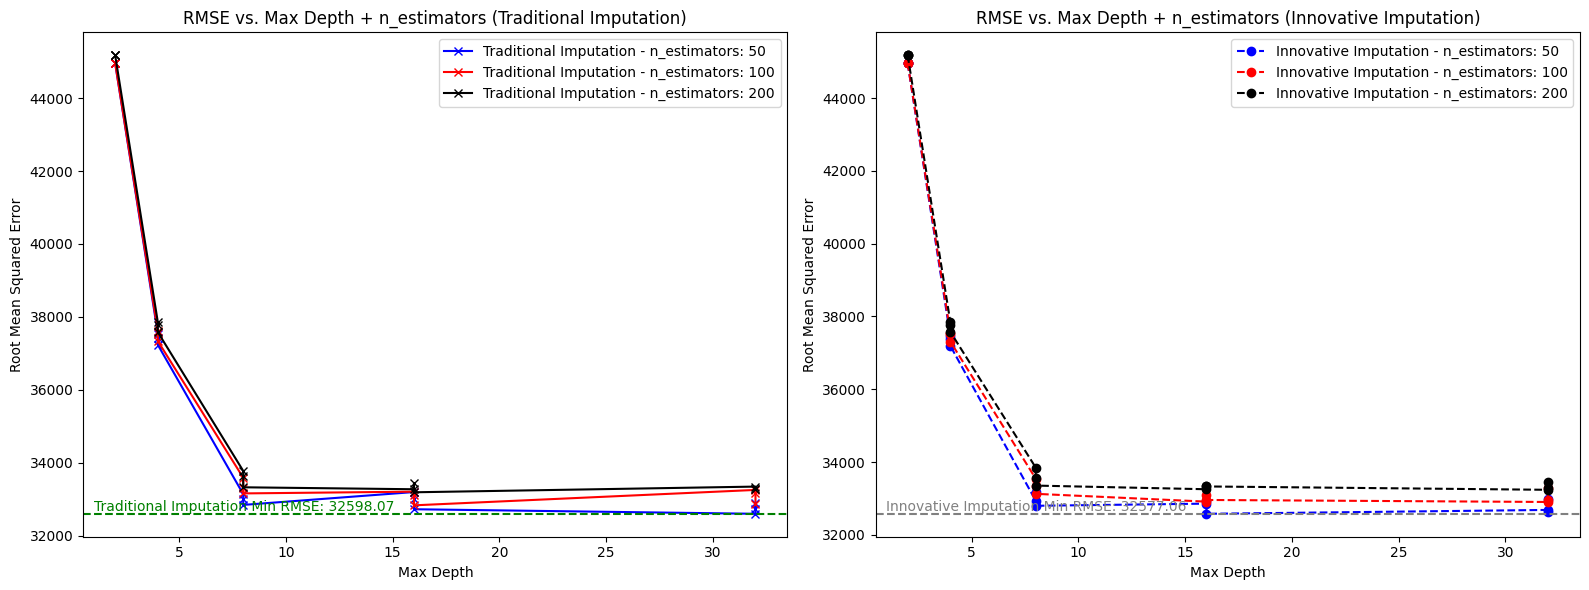

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have colors and estimators_values defined similarly to the provided code
colors = {50: 'blue', 100: 'red', 200: 'black'}
estimators_values = results_df_traditional['param_n_estimators'].unique()

# Plotting for results_df_traditional
plt.figure(figsize=(16, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Subplot 1 for results_df_traditional
for n in estimators_values:
    subset = results_df_traditional[results_df_traditional['param_n_estimators'] == n]
    plt.plot(subset['param_max_depth'], subset['rmse'], label=f'Traditional Imputation - n_estimators: {n}', color=colors[n], marker='x')

# Getting the minimum RMSE value and drawing a dotted line
min_rmse_traditional = results_df_traditional['rmse'].min()
plt.axhline(y=min_rmse_traditional, color='green', linestyle='--', linewidth=1.5)
plt.text(x=1, y=min_rmse_traditional, s=f'Traditional Imputation Min RMSE: {min_rmse_traditional:.2f}', color='green', va='bottom')
plt.title('RMSE vs. Max Depth + n_estimators (Traditional Imputation)')
plt.xlabel('Max Depth')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# Plotting for the previous results_df
plt.subplot(1, 2, 2)  # Subplot 2 for original results_df
for n in estimators_values:
    subset = results_df[results_df['param_n_estimators'] == n]
    plt.plot(subset['param_max_depth'], subset['rmse'], label=f'Innovative Imputation - n_estimators: {n}', color=colors[n], linestyle='--', marker='o')

# Getting the minimum RMSE value and drawing a dotted line
min_rmse_original = results_df['rmse'].min()
plt.axhline(y=min_rmse_original, color='gray', linestyle='--', linewidth=1.5)
plt.text(x=1, y=min_rmse_original, s=f'Innovative Imputation Min RMSE: {min_rmse_original:.2f}', color='gray', va='bottom')
plt.title('RMSE vs. Max Depth + n_estimators (Innovative Imputation)')
plt.xlabel('Max Depth')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()